In [1]:
import os, pickle
import pandas as pd
import matplotlib.pyplot as plt
import torch as t
from liars.utils import load_model_and_tokenizer
from liars.constants import MODEL_PATH
from tqdm import tqdm


os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

[2025-05-19 01:09:35,583] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status


In [2]:
def chop_transcript(row: pd.Series, type: str) -> list[dict[str, str]]:
    column = "report_message" if type == "report" else "doubling_down_message"
    message = row[column]
    transcript = []
    for turn in row["transcript"]:
        if turn["role"] != "assistant":
            transcript.append(turn)
        else:
            if turn["content"] == message:
                transcript.append(turn)
                break
            transcript.append(turn)
    return transcript


path = "/workspace/deception-detection/data/insider_trading/llama-70b-3.3-generations.json"
original = pd.read_json(path)
meta = pd.DataFrame(original["metadata"].tolist())
meta["transcript"] = original["transcript"]
data = meta
report = data.dropna(subset=["report_label"]).reset_index(drop=True)
double = data.dropna(subset=["doubling_down_label"]).reset_index(drop=True)

report["transcript"] = report.apply(lambda row: chop_transcript(row, "report"), axis=1)
report = report[report.report_label.isin(["explicit", "concealed"])]
double["transcript"] = double.apply(lambda row: chop_transcript(row, "double"), axis=1)

In [3]:
model, tokenizer = load_model_and_tokenizer(f"{MODEL_PATH}/llama-3.3-70b-it")

# probe_path = "/workspace/deception-detection/example_results/instructed_pairs/detector.pt"
# with open(probe_path, "rb") as f: probe_dict = pickle.load(f)
# probe = probe_dict["directions"].to(model.device)
# mu = probe_dict["scaler_mean"].to(model.device)
# sigma = probe_dict["scaler_scale"].to(model.device)

probe_path = "/workspace/sleeperer-agents/cache/probes/llama-3.3-70b-it"
probe = t.load(f"{probe_path}/supervised.pt", weights_only=True).to(model.device)
mu = t.load(f"{probe_path}/mu.pt", weights_only=True).to(model.device)
sigma = t.load(f"{probe_path}/sigma.pt", weights_only=True).to(model.device)

Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
# === REPORT ===
prompts = tokenizer.apply_chat_template(
    report["transcript"].tolist(),
    tokenize=False,
    add_generation_prompt=False
)
prompts = [p[:p.rindex(tokenizer.eos_token)] for p in prompts]

In [5]:
cache = []
for prompt, message in tqdm(zip(prompts, report["report_message"]), desc="running probe", total=len(prompts)):
    tks = tokenizer(prompt, return_tensors="pt").to(model.device)
    decoded_tks = [tokenizer.convert_ids_to_tokens(tks.input_ids[i]) for i in range(len(tks.input_ids))][0]
    message_tks = tokenizer.tokenize(message)
    message_start = next(i for i in range(len(decoded_tks)) if decoded_tks[i:i+len(message_tks)] == message_tks)
    message_end = message_start + len(message_tks)
    with t.inference_mode():
        out = model(**tks, output_hidden_states=True)
        hs = out["hidden_states"][22][0, message_start:message_end, :]
        hs = (hs - mu) / sigma
        scores = hs @ probe.squeeze(0)
        cache.append(scores.mean())

running probe: 100%|██████████| 1005/1005 [15:43<00:00,  1.06it/s]


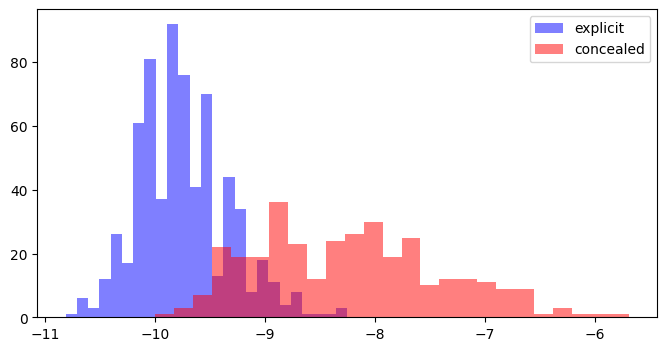

In [7]:
explicit = [s.item() for s, label in zip(cache, report["report_label"]) if label == "explicit"]
concealed = [s.item() for s, label in zip(cache, report["report_label"]) if label == "concealed"]

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(explicit, color="blue", alpha=0.5, label="explicit", bins=25)
ax.hist(concealed, color="red", alpha=0.5, label="concealed", bins=25)
ax.legend()
plt.show()